In [6]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
import re
from captions_loader import setup_coco
import networkx as nx
from langchain_core.prompts import PromptTemplate, FewShotPromptTemplate

Step 1, read the dataset and generate concept levels.

In [7]:
def setup_coco(data_dir, data_type='train2017'):
    """
    Setup COCO dataset
    data_dir: root directory of COCO dataset
    data_type: 'train2017' or 'val2017'
    """
    annotation_file = os.path.join(data_dir, f'captions_{data_type}.json')
    coco = COCO(annotation_file)
    return coco

In [312]:
import os
os.environ['OPENAI_API_KEY'] = "xxx"

In [307]:
from openai import OpenAI
import os
from typing import Optional
import logging

def call_openai_api(prompt, model="gpt-4o-mini"):
    try:
        api_key = os.getenv("OPENAI_API_KEY")
        if not api_key:
            raise ValueError("OpenAI API key not found. Set OPENAI_API_KEY environment variable.")
            
        client = OpenAI(api_key=api_key)
        
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        
        return response.choices[0].message.content
    except Exception as e:
        logging.error(f"Error calling OpenAI API: {str(e)}")
        return None

In [308]:
#PROMPT of generating concept reduce the example to 5
PROMPT_1 = """

Definition:
A general concept is a broad idea or category that captures common attributes or qualities shared by multiple specific instances or objects, which may be concrete or abstract. It simplifies complex information by grouping similar instances together. For example: 1) The concept of “animal” encompasses all living organisms that can move and consume food. 2) The concept of “freedom” describes a state of being free from constraints or oppression, applicable in various social, political, and personal contexts.

Instruction:
Given a set of captions describing one single image, determine the first-level main general concept, so avoid being too general. The first-level concept should describe a general idea of the original caption. The concept should be a short phrase or a brief phrase that captures the general idea of the image (represented by the captions). Emphasize more on events or themes rather than objects or actions. Concepts MUST use canonical vocabulary (e.g. singular; present tense). Do not provide explanations. Write the concept in an <output> section.

Example 1:
Captions:
The tray on the bed has a pastry and two mugs on it.
A tray with coffee and a pastry on it.
A tray is full of breakfast foods and drinks on a bed.
coffee cream and a croissant on a tray
A tray on a bed with food and drink.
Output:
<output>Breakfast</output>

Example 2:
Captions:
Man in dress shirt and orange tie standing inside a building.
a male with a beard and orange tie
A man wearing a neck tie and a white shirt.
A man posing for the picture in a building
A man dressed in a shirt and tie standing in a lobby.
Output:
<output>Business Attire</output>

Example 3:
Captions:
Many small children are posing together in the black and white photo.
A vintage school picture of grade school aged children.
A black and white photo of a group of kids.
A group of children standing next to each other.
A group of children standing and sitting beside each other.
Output:
<output>Education</output>

Example 4:
Captions:
there is a very tall giraffe standing in the wild
A giraffe is standing by some brush in a field.
A giraffe standing in a dirt field near a tree.
A single giraffe standing in a brushy area looking at the photographer
A giraffe standing in dry dead brush on the savannah.
Output:
<output>Wildlife</output>

Example 5:
Captions:
Ornate wedding cake ready at the hotel reception
A tall multi layer cake sitting on top of a blue table cloth.
A wedding cake with flowers in a banquet hall.
Nicely decorated three tier wedding cake with topper.
A very ornate, three layered wedding cake in a banquet room.
Output:
<output>Wedding</output>
"""
PROMPT_2 = """
Example 1:
Captions:
The tray on the bed has a pastry and two mugs on it.
A tray with coffee and a pastry on it.
A tray is full of breakfast foods and drinks on a bed.
coffee cream and a croissant on a tray
A tray on a bed with food and drink.
Level1 Concept: Breakfast
Output:
<output>Meal</output>

Example 2:
Captions:
Man in dress shirt and orange tie standing inside a building.
a male with a beard and orange tie
A man wearing a neck tie and a white shirt.
A man posing for the picture in a building
A man dressed in a shirt and tie standing in a lobby.
Level1 Concept: Business Attire
Output:
<output>Business</output>

Example 3:
Captions:
Many small children are posing together in the black and white photo.
A vintage school picture of grade school aged children.
A black and white photo of a group of kids.
A group of children standing next to each other.
A group of children standing and sitting beside each other.
Level1 Concept: Education
Output:
<output>Learning</output>

Example 4:
Captions:
there is a very tall giraffe standing in the wild
A giraffe is standing by some brush in a field.
A giraffe standing in a dirt field near a tree.
A single giraffe standing in a brushy area looking at the photographer
A giraffe standing in dry dead brush on the savannah.
Level1 Concept: Wildlife
Output:
<output>Nature</output>

Example 5:
Captions:
Ornate wedding cake ready at the hotel reception
A tall multi layer cake sitting on top of a blue table cloth.
A wedding cake with flowers in a banquet hall.
Nicely decorated three tier wedding cake with topper.
A very ornate, three layered wedding cake in a banquet room.
Level1 Concept: Wedding
Output:
<output>Celebration</output>
"""
PROMPT_3 = """Example 1:
Captions:
The tray on the bed has a pastry and two mugs on it.
A tray with coffee and a pastry on it.
A tray is full of breakfast foods and drinks on a bed.
coffee cream and a croissant on a tray
A tray on a bed with food and drink.
Level1 Concept: Breakfast
Level2 Concept: Meal
Output:
<output>Food</output>

Example 2:
Captions:
Man in dress shirt and orange tie standing inside a building.
a male with a beard and orange tie
A man wearing a neck tie and a white shirt.
A man posing for the picture in a building
A man dressed in a shirt and tie standing in a lobby.
Level1 Concept: Business Attire
Level2 Concept: Business
Output:
<output>Career</output>

Example 3:
Captions:
Many small children are posing together in the black and white photo.
A vintage school picture of grade school aged children.
A black and white photo of a group of kids.
A group of children standing next to each other.
A group of children standing and sitting beside each other.
Level1 Concept: Education
Level2 Concept: Learning
Output:
<output>Personal Development</output>

Example 4:
Captions:
there is a very tall giraffe standing in the wild
A giraffe is standing by some brush in a field.
A giraffe standing in a dirt field near a tree.
A single giraffe standing in a brushy area looking at the photographer
A giraffe standing in dry dead brush on the savannah.
Level1 Concept: Wildlife
Level2 Concept: Nature
Output:
<output>Life</output>

Example 5:
Captions:
Ornate wedding cake ready at the hotel reception
A tall multi layer cake sitting on top of a blue table cloth.
A wedding cake with flowers in a banquet hall.
Nicely decorated three tier wedding cake with topper.
A very ornate, three layered wedding cake in a banquet room.
Level1 Concept: Wedding
Level2 Concept: Celebration
Output:
<output>Tradition</output>
"""
PROMPT_4 = """
Example 1:
Captions:
The tray on the bed has a pastry and two mugs on it.
A tray with coffee and a pastry on it.
A tray is full of breakfast foods and drinks on a bed.
coffee cream and a croissant on a tray
A tray on a bed with food and drink.
Level1 Concept: Breakfast
Level2 Concept: Meal
Level3 Concept: Food
Output:
<output>Nutrition</output>

Example 2:
Captions:
Man in dress shirt and orange tie standing inside a building.
a male with a beard and orange tie
A man wearing a neck tie and a white shirt.
A man posing for the picture in a building
A man dressed in a shirt and tie standing in a lobby.
Level1 Concept: Business Attire
Level2 Concept: Business
Level3 Concept: Career
Output:
<output>Personal Development</output>

Example 3:
Captions:
Many small children are posing together in the black and white photo.
A vintage school picture of grade school aged children.
A black and white photo of a group of kids.
A group of children standing next to each other.
A group of children standing and sitting beside each other.
Level1 Concept: Education
Level2 Concept: Learning
Level3 Concept: Personal Development
Output:
<output>Human Growth</output>

Example 4:
Captions:
there is a very tall giraffe standing in the wild
A giraffe is standing by some brush in a field.
A giraffe standing in a dirt field near a tree.
A single giraffe standing in a brushy area looking at the photographer
A giraffe standing in dry dead brush on the savannah.
Level1 Concept: Wildlife
Level2 Concept: Nature
Level3 Concept: Life
Output:
<output>Ecosystem</output>

Example 5:
Captions:
Ornate wedding cake ready at the hotel reception
A tall multi layer cake sitting on top of a blue table cloth.
A wedding cake with flowers in a banquet hall.
Nicely decorated three tier wedding cake with topper.
A very ornate, three layered wedding cake in a banquet room.
Level1 Concept: Wedding
Level2 Concept: Celebration
Level3 Concept: Tradition
Output:
<output>Cultural Heritage</output>
"""

In [92]:

def get_concept_level1(image_captions):
    prompt = PROMPT_1
    return call_openai_api(prompt + "\n".join(image_captions))
def get_concept_level2(image_captions, concept_level1):
   """
   Get concept level 2 from caption
   
   """
   prompt = PROMPT_2
   image_captions = "\n".join(image_captions)
   return call_openai_api(f""" 
Definition:
A general concept is a broad idea or category that captures common attributes or qualities shared by multiple specific instances or objects, which may be concrete or abstract. It simplifies complex information by grouping similar instances together. For example: 1) The concept of “animal” encompasses all living organisms that can move and consume food. 2) The concept of “freedom” describes a state of being free from constraints or oppression, applicable in various social, political, and personal contexts.

Instruction:
Given a set of captions describing one single image, determine the second-level main general concept. The second-level concept should describe a general idea of the first-level concept. The concept should be a short phrase or a brief phrase that captures the general idea of the image (represented by the captions). Emphasize more on events or themes rather than objects or actions. Concepts MUST use canonical vocabulary (e.g. singular; present tense). Do not provide explanations. Write the concept in an <output> section.

Examples:\n
{prompt}
Given Captions:\n
{image_captions}
                          
First Level Concept: {concept_level1}""")

def get_concept_level3(image_captions, concept_level1, concept_level2):
   """
   Get concept level 3 from caption
   """
   prompt = PROMPT_3
   image_captions = "\n".join(image_captions)
   return call_openai_api(f""" 
Definition:
A general concept is a broad idea or category that captures common attributes or qualities shared by multiple specific instances or objects, which may be concrete or abstract. It simplifies complex information by grouping similar instances together. For example: 1) The concept of “animal” encompasses all living organisms that can move and consume food. 2) The concept of “freedom” describes a state of being free from constraints or oppression, applicable in various social, political, and personal contexts.

Instruction:
Given a set of captions describing one single image, determine the third-level main general concept. The third-level concept should describe a general idea of the second-level concept. The concept should be a short phrase or a brief phrase that captures the general idea of the image (represented by the captions). Emphasize more on events or themes rather than objects or actions. Concepts MUST use canonical vocabulary (e.g. singular; present tense). Do not provide explanations. Write the concept in an <output> section.
Examples:\n
{prompt}
                          
Given Captions:\n
{image_captions}
First Level Concept: {concept_level1}
Second Level Concept: {concept_level2}                          
""")

def get_concept_level4(image_captions, concept_level1, concept_level2, concept_level3):
   """
   Get concept level 4 from caption
   """
   prompt = PROMPT_4
   image_captions = "\n".join(image_captions)
   return call_openai_api(f""" 
Definition:
A general concept is a broad idea or category that captures common attributes or qualities shared by multiple specific instances or objects, which may be concrete or abstract. It simplifies complex information by grouping similar instances together. For example: 1) The concept of “animal” encompasses all living organisms that can move and consume food. 2) The concept of “freedom” describes a state of being free from constraints or oppression, applicable in various social, political, and personal contexts.

Instruction:
Given a set of captions describing one single image, determine the fourth-level main general concept. The fourth-level concept should describe a general idea of the third-level concept. The concept should be a short phrase or a brief phrase that captures the general idea of the image (represented by the captions). Emphasize more on events or themes rather than objects or actions. Concepts MUST use canonical vocabulary (e.g. singular; present tense). Do not provide explanations. Write the concept in an <output> section.
Examples:\n
{prompt}
Given Captions:\n
{image_captions}

First Level Concept: {concept_level1}
Second Level Concept: {concept_level2}      
Third Level Concept: {concept_level3}                     
""")

In [313]:
def extract_output_content(text):
   """Extract content between output tags"""
   pattern = '<output>(.*?)</output>'
   match = re.search(pattern, text)
   return match.group(1) if match else None

def extract_multiple_output_content(text):
   """Extract content between output tags"""
   pattern = '<caption>(.*?)</caption>'
   matches = re.findall(pattern, text)
   return matches

In [81]:
data_dir = './dataset'
coco = setup_coco(data_dir)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


In [86]:
x = "<output>Transportation</output>"
print(extract_output_content(x))

Transportation


In [311]:
imgIds = coco.getImgIds()
count = 0
for img_id in imgIds:
    annIds = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(annIds)
    anns = [ann['caption'] for ann in anns]
    print(anns)
    concept_level1 = extract_output_content(get_concept_level1(anns))
    concept_level2 = extract_output_content(get_concept_level2(anns, concept_level1))
    concept_level3 = extract_output_content(get_concept_level3(anns, concept_level1, concept_level2))
    concept_level4 = extract_output_content(get_concept_level4(anns, concept_level1, concept_level2, concept_level3))
    break #remove this if you want to run for all images
    #different levels might have the same concept
    #If we have img A, other images' level4 concept might be the same as A's level1 concept

ERROR:root:Error calling OpenAI API: Error code: 403 - {'error': {'message': 'Project `proj_7VJdFZFYMy0R2ypHF1bnxx3O` does not have access to model `gpt-4o-mini`', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']
None


TypeError: expected string or bytes-like object

In [94]:
print(concept_level1, concept_level2)

Transportation Mobility <output>Transportation</output> <output>Mobility</output>


In [156]:
def add_image_nodes(G, img_id, coco, concept_level1, concepts, root_node = "HOME_ROOT"):
    try:
        annIds = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(annIds)
        anns = [ann['caption'] for ann in anns]

        if not concept_level1:
            logging.error(f"Invalid concept_level1 for image {img_id}")
            return

        # Always need to add image node
        print(img_id)
        new_nodes = [(img_id, {'type': 'image'})]
        new_edges = []
        if root_node not in G:
            print("ROOT existed now")
            new_nodes.append((root_node, {'type': 'level5'}))
        if concept_level1 not in G:
            print(concept_level1)
            new_nodes.append((concept_level1, {'type': 'level1'}))

        if concept_level1 not in concepts:
            concepts[concept_level1] = True
            concept_level2 = extract_output_content(get_concept_level2(anns, concept_level1))
            
            # Add level1 node and edge
            new_nodes.append((concept_level1, {'type': 'level1'}))
            new_edges.append((img_id, concept_level1))
            
            if concept_level2 not in concepts:
                concepts[concept_level2] = True
                concept_level3 = extract_output_content(get_concept_level3(anns, concept_level1, concept_level2))
                
                # Add level2 node and edge
                new_nodes.append((concept_level2, {'type': 'level2'}))
                new_edges.append((concept_level1, concept_level2))
                
                if concept_level3 not in concepts:
                    concepts[concept_level3] = True
                    concept_level4 = extract_output_content(get_concept_level4(anns, concept_level1, concept_level2, concept_level3))
                    
                    # Add level3 node and edge
                    new_nodes.append((concept_level3, {'type': 'level3'}))
                    new_edges.append((concept_level2, concept_level3))
                    
                    if concept_level4 not in concepts:
                        concepts[concept_level4] = True
                        # Add level4 node and edge
                        new_nodes.append((concept_level4, {'type': 'level4'}))
                        new_edges.append((concept_level3, concept_level4))
                        # add root node
                        new_edges.append((concept_level4, root_node))
                    else:
                        # Connect to existing level4
                        new_edges.append((concept_level3, concept_level4))
                else:
                    # Connect to existing level3
                    new_edges.append((concept_level2, concept_level3))
            else:
                # Connect to existing level2
                new_edges.append((concept_level1, concept_level2))
        else:
            # Connect to existing level1
            new_edges.append((img_id, concept_level1))

        # Add all new nodes and edges at once
        print(new_edges, new_nodes)

        G.add_nodes_from(new_nodes)
        G.add_edges_from(new_edges)

            
    except Exception as e:
        logging.error(f"Error processing image {img_id}: {str(e)}")

In [314]:
G = nx.DiGraph()
concepts = {}
count = 0
for img_id in imgIds:
   count+=1
   annIds = coco.getAnnIds(imgIds=img_id)
   anns = coco.loadAnns(annIds)
   anns = [ann['caption'] for ann in anns]
   concept_level1 = extract_output_content(get_concept_level1(anns)) # get captions form the annotations
   add_image_nodes(G, img_id, coco, concept_level1, concepts)
   if count == 10:
      break
   #nx.write_graphml(G, "concept_hierarchy.graphml")

   #remove this if you want to run for all images


391895
ROOT existed now
Motorcycling
[(391895, 'Motorcycling'), ('Motorcycling', 'Adventure'), ('Adventure', 'Exploration'), ('Exploration', 'Outdoor Experience'), ('Outdoor Experience', 'HOME_ROOT')] [(391895, {'type': 'image'}), ('HOME_ROOT', {'type': 'level5'}), ('Motorcycling', {'type': 'level1'}), ('Motorcycling', {'type': 'level1'}), ('Adventure', {'type': 'level2'}), ('Exploration', {'type': 'level3'}), ('Outdoor Experience', {'type': 'level4'})]
522418
Cake Cutting
[(522418, 'Cake Cutting'), ('Cake Cutting', 'Event'), ('Event', 'Celebration'), ('Celebration', 'Ritual'), ('Ritual', 'HOME_ROOT')] [(522418, {'type': 'image'}), ('Cake Cutting', {'type': 'level1'}), ('Cake Cutting', {'type': 'level1'}), ('Event', {'type': 'level2'}), ('Celebration', {'type': 'level3'}), ('Ritual', {'type': 'level4'})]
184613
Childhood
[(184613, 'Childhood'), ('Childhood', 'Innocence'), ('Innocence', 'Wonder'), ('Wonder', 'Nature Exploration'), ('Nature Exploration', 'HOME_ROOT')] [(184613, {'type': 

In [158]:
print(list(G.nodes))

[391895, 'HOME_ROOT', 'Motorcycling', 'Transportation', 'Mobility', 'Development', 522418, 'Food Preparation', 'Cooking', 'Domestic Activity', 'Human Behavior', 184613, 'Farming', 'Agriculture', 'Food Production', 'Economy', 318219, 'Technology', 'Digital Interaction', 'Connectivity', 'Communication', 554625, 'Education', 'Learning', 'Personal Development', 'Human Growth', 574769, 'Domestic Scene', 'Aesthetics', 'Home Life', 'Human Environment', 60623, 'Birthday', 'Celebration', 'Tradition', 'Cultural Heritage', 309022, 5802, 222564]


In [285]:
def visualize_concept_hierarchy(G):
    plt.figure(figsize=(20, 12))  # Increased figure size for better visibility
    
    # Create hierarchical layout using Graphviz
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=TB')
    
    # Draw nodes by type with different colors
    node_colors = []
    node_sizes = []
    labels = {}
    
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        # Customize node appearance based on type
        if node_type == 'image':
            node_colors.append('lightblue')
            node_sizes.append(1000)
            # Shorten image names if they're too long
            labels[node] = str(node)[:20] + '...' if len(str(node)) > 20 else str(node)
        elif node_type == 'level1':
            node_colors.append('lightgreen')
            node_sizes.append(2000)
            labels[node] = str(node)
        elif node_type == 'level2':
            node_colors.append('yellow')
            node_sizes.append(2500)
            labels[node] = str(node)
        elif node_type == 'level3':
            node_colors.append('orange')
            node_sizes.append(3000)
            labels[node] = str(node)
        elif node_type == 'level4':
            node_colors.append('red')
            node_sizes.append(3500)
            labels[node] = str(node)
        elif node_type == 'level5':  # Root node
            node_colors.append('purple')
            node_sizes.append(4000)
            labels[node] = str(node)
    
    # Draw edges first (behind nodes)
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          node_shape='o')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos,
                           labels=labels,
                           font_size=10,
                           font_weight='bold')
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=c, label=l, markersize=10)
                      for c, l in [('lightblue', 'Image'),
                                 ('lightgreen', 'Level 1'),
                                 ('yellow', 'Level 2'),
                                 ('orange', 'Level 3'),
                                 ('red', 'Level 4'),
                                 ('purple', 'Root')]]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title("Concept Hierarchy Tree", pad=20, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

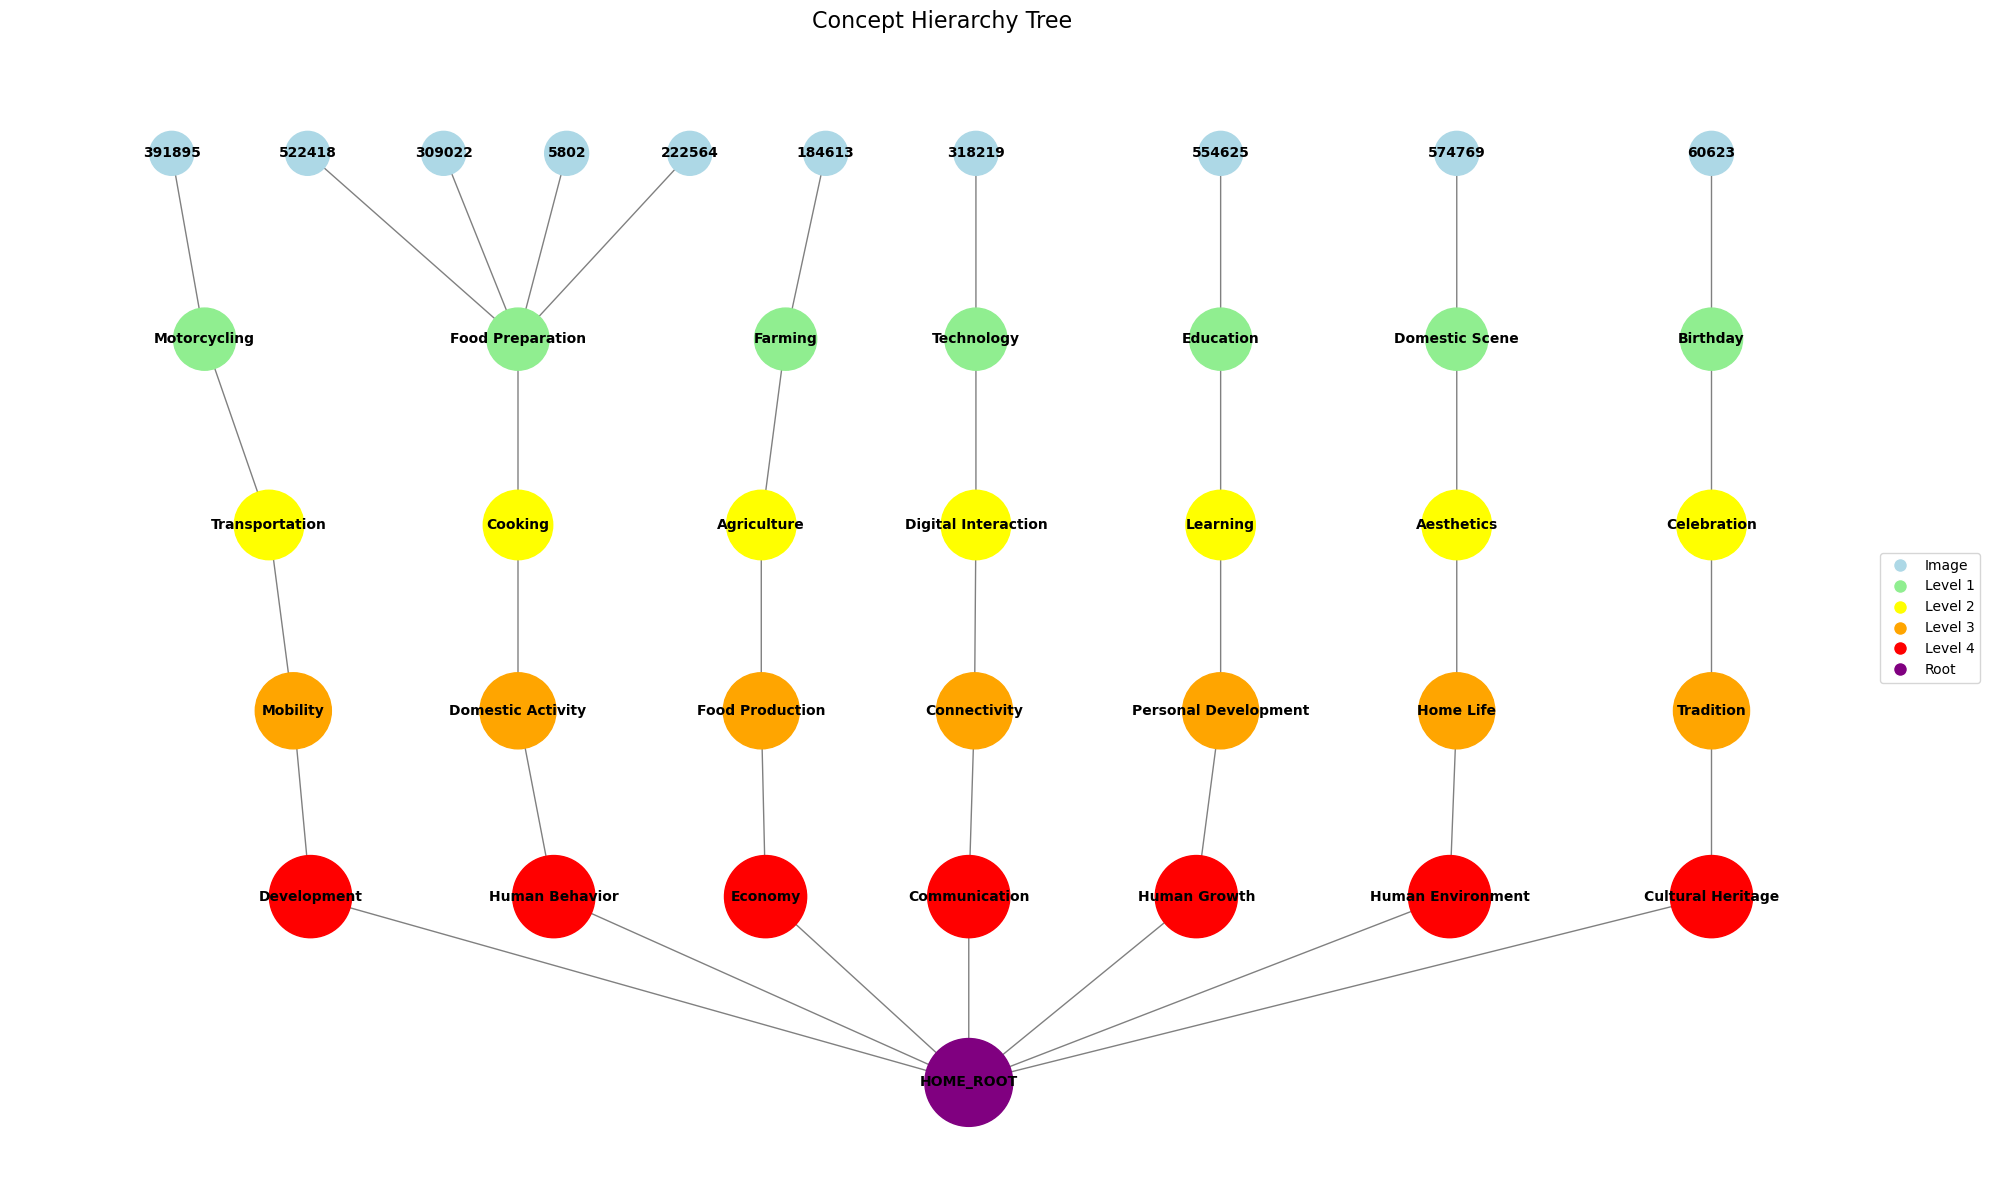

In [286]:
G = nx.read_graphml("concept_hierarchy.graphml")
visualize_concept_hierarchy(G)

In [161]:
nx.write_graphml(G, "concept_hierarchy.graphml")

In [367]:
cot = """
* Begin your answer with a <thinking> section.
* Inside the <thinking> section:
     - Briefly analyze the captions;
     - Outline your approach;
     - Use a "Chain of Thought" reasoning process, breaking down your thought process;
     - Present a clear plan of steps for implementation;
     - Write the new general captions.
* Include a <reflection> section for each step in the <thinking> section where you:
     - Review your logical reasoning;
- Ensure all requirements from the instruction are met;
     - Check for potential errors or oversights;
     - Confirm and adjust the captions if necessary;
     - Think if you need to generate more <reflection> sections.
* Close all <reflection> sections as well as the <thinking> section at their conclusion.
* Write the new captions, each within <caption> </caption> tag, in an <output> section.
* Always use these tags in your responses. Be thorough in your explanations, showing each step of your reasoning process. Aim to be precise and logical in your approach and break down complex problems into simpler components.
* Your tone should be analytical and slightly formal, focusing on clearly communicating your thought process.
* Do not include other text on a line containing a tag.
"""
def get_general_captions(captions, concept):
   length = len(captions)
   return call_openai_api("""
                          
                          
   Definition:
A general concept is a broad idea or category that captures common attributes or qualities shared by multiple specific instances or objects, which may be concrete or abstract. It simplifies complex information by grouping similar instances together. For example: 1) The concept of “animal” encompasses all living organisms that can move and consume food. 2) The concept of “freedom” describes a state of being free from constraints or oppression, applicable in various social, political, and personal contexts.

Instruction:
Given a group of captions that share one common general concept: {concept}, paraphrase the original captions. For each caption, consider a more generalized version of the caption that focuses on the general theme rather than specific details. 
Each new caption MUST be able to represent the shared information in every original caption without adding anything that is not in every caption. 
Ensure every generated caption can describe all of the captions in the group. Each new caption should be related to the concept of {concept}. Each generated caption must be unique. Generate {length} unique captions. Write each new caption within <caption> </caption> tags, in an <output> section.
Captions:
   """ + "\n".join(captions), model='o1-mini')

def get_hierarchy_levels(G: nx.Graph, concept: str):
    try:
        level2 = next(G.successors(concept))
        level3 = next(G.successors(level2))
        level4 = next(G.successors(level3))
        return level2, level3, level4
    except StopIteration:
        logging.error(f"Incomplete hierarchy for concept: {concept}")
        return None, None, None

In [372]:
import pickle
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

data_dir = './dataset'
coco = setup_coco(data_dir)

G = nx.read_graphml("concept_hierarchy.graphml")
level1_nodes = [n for n,d in G.nodes(data=True) if d['type']=='level1']
dataset= []
#in parallel
def myfunc(concept):
   try:
      images = list(G.predecessors(concept))
      if not images:
         logging.warning(f"No images found for concept: {concept}")
         return
      group1_aan = []

      for i in images:
         annIds = coco.getAnnIds(int(i))
         anns = coco.loadAnns(annIds)
         anns = [ann['caption'] for ann in anns]
         group1_aan.extend(anns)
      level2, level3, level4 = get_hierarchy_levels(G, concept)
      x = get_general_captions(group1_aan, concept)
      level1_concept = extract_multiple_output_content(x)
      res = {
         "images": images,
         "general_captions_level1": level1_concept,
         # "general_captions_level2": extract_multiple_output_content(get_general_captions(group1_aan, level2)),
         # "general_captions_level3": extract_multiple_output_content(get_general_captions(group1_aan, level3)),
         # "general_captions_level4": extract_multiple_output_content(get_general_captions(group1_aan, level4)),
         "original_category": group1_aan,
         "level1": concept,
         "level2": level2,
         "level3": level3,
         "level4": level4
      }
   except Exception as e:
      logging.error(f"Error processing concept {concept}: {str(e)}")
      return None
   return res

with ProcessPoolExecutor(max_workers=8, mp_context=mp.get_context('fork')) as executor:
   for r in executor.map(myfunc, level1_nodes):
      dataset.append(r)

   
   # dataset.append({
   #    "images": images,
   #    "general_captions_level1": level1_concept,
   #    # "general_captions_level2": extract_multiple_output_content(get_general_captions(group1_aan, level2)),
   #    # "general_captions_level3": extract_multiple_output_content(get_general_captions(group1_aan, level3)),
   #    # "general_captions_level4": extract_multiple_output_content(get_general_captions(group1_aan, level4)),
   #    "original_category": group1_aan,
   #    "level1": concept,
   #    "level2": level2,
   #    "level3": level3,
   #    "level4": level4
   # })
print(dataset)
with open("final_dataset", 'wb') as f:
   pickle.dump(dataset, f)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
[{'images': ['391895'], 'general_captions_level1': ['A man operating a motorcycle on an unpaved road.', 'Someone riding a motorbike through a rural landscape.', 'An individual traveling by motorcycle along a dirt path.', 'A rider navigating a natural trail on a motorcycle.', 'A person on a motorcycle journeying through the countryside.'], 'original_category': ['A man with a red helmet on a small moped on a dirt road. ', 'Man riding a motor bike on a dirt road on the countryside.', 'A man riding on the back of a motorcycle.', 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ', 'A man in a red shirt and a red hat is on a motorcycle on a hill side.'], 'level1': 'Motorcycling', 'level2': 'Transportation', 'level3': 'Mobility', 'level4': 'Development'}, {'images': ['522418', '309022', '5802', '222564'], 'gene

train and val dataset of the original coco. 
split the graph bsaed on the level 1, counting the number of level 1 and split them (80, 20)
save to train, test
3000000 
cost, time
10 -> 0.5 $ -> 3mins -> 0.1$
10 -> 0.3 $

110000 the cate of the coco



In [373]:
with open("final_dataset", 'rb') as f:
    temp = pickle.load(f)
img = temp[1]['images']
print(temp[1]['general_captions_level1'])
print(temp[1]['original_category'])

['Individuals engaged in food preparation activities within a professional kitchen.', 'People working together to cook and prepare meals in a commercial kitchen setting.', 'Culinary professionals handling various cooking tasks in a modern kitchen environment.', 'Chefs and cooks collaborating to prepare and manage food in a stainless steel kitchen.', 'Kitchen staff operating appliances and performing food preparation duties in a professional setting.']
['A woman wearing a net on her head cutting a cake. ', 'A woman cutting a large white sheet cake.', 'A woman wearing a hair net cutting a large sheet cake.', 'there is a woman that is cutting a white cake', "A woman marking a cake with the back of a chef's knife. ", 'A commercial stainless kitchen with a pot of food cooking. ', 'Some food sits in a pot in a kitchen. ', 'A kitchen has all stainless steel appliances and counters.', 'a kitchen with a sink and many cooking machines and a pot of food', 'Food cooks in a pot on a stove in a kitc

In [252]:
def get_new_merged_concept(concept, smallest_sibling, parent, images, smallest_sibling_imags):
   return call_openai_api(f"""
   Definition:
A general concept is a broad idea or category that captures common attributes or qualities shared by multiple specific instances or objects, which may be concrete or abstract. It simplifies complex information by grouping similar instances together. For example: 1) The concept of “animal” encompasses all living organisms that can move and consume food. 2) The concept of “freedom” describes a state of being free from constraints or oppression, applicable in various social, political, and personal contexts.

Instruction:
Group 1 of captions have the concept {concept} and group 2 of captions have the concept {smallest_sibling}. Combine two groups together and determine a new unified concept. The concept should be a short phrase or a brief phrase that captures the general idea of the image (represented by the captions). The new unified concept should appropriately represent all the captions from both groups and also belong to the higher-level general concept {parent}. Concepts MUST use canonical vocabulary (e.g. singular; present tense). The purpose of this is to streamline the concept hierarchy and reduce fragmentation. Do not provide explanations. Write the new unified general concept in an <output> section.

Group 1 Captions:                           
""" + "\n".join(images)
+ """
Group 2 Captions:      
"""+ "\n".join(smallest_sibling_imags))

In [274]:
def find_and_merge_small_concepts(G: nx.DiGraph, min_images: int = 5):
    try:
        # 1. Find Level1 concepts with fewer than 5 images
        small_groups = [(n, list(G.predecessors(n))) 
                       for n, d in G.nodes(data=True) 
                       if d['type'] == 'level1' and len(list(G.predecessors(n))) < min_images]
        
        if not small_groups:
            logging.info("No small concept groups found")
            return False
            
        for concept, images in small_groups:
            try:
                # 2. Get the Level2 parent
                parent = next(G.successors(concept))
                
                # 3. Get all Level1 siblings (other children of the parent)
                siblings = [n for n in G.predecessors(parent) 
                          if n != concept and G.nodes[n]['type'] == 'level1']
                
                if not siblings:
                    G.remove_node(concept)
                    continue
                
                # 4. Find the sibling with fewest images
                smallest_sibling = min(siblings, 
                                    key=lambda x: len(list(G.predecessors(x))))
                
                smallest_sibling_images = list(G.predecessors(smallest_sibling))
                
                # 5. Get new merged concept using existing function (not shown)
                all_images = images + smallest_sibling_images
                print(all_images)
                new_concept = get_new_merged_concept(
                    concept=concept,
                    smallest_sibling=smallest_sibling,
                    parent=parent,
                    images=images,
                    smallest_sibling_imags=smallest_sibling_images
                )
                
                # 6. Add new concept and connect everything
                G.add_node(new_concept, type='level1')
                
                # Connect images to new concept
                for img in all_images:
                    G.add_edge(img, new_concept)
                
                # Connect new concept to parent
                G.add_edge(new_concept, parent)
                
                # 7. Remove old concepts
                G.remove_node(concept)
                G.remove_node(smallest_sibling)
                
                logging.info(f"Successfully merged concepts {concept} and {smallest_sibling} into {new_concept}")
                return True
                
            except Exception as e:
                logging.error(f"Error processing concept {concept}: {e}")
                continue
                
        return False
        
    except Exception as e:
        logging.error(f"Error in find_and_merge_small_concepts: {e}")
        return False



In [275]:
G = nx.read_graphml("concept_hierarchy.graphml")
changes_made = find_and_merge_small_concepts(G)
if changes_made:
    print("Successfully merged some concepts")
else:
    print("No merges were performed")

No merges were performed


In [277]:
def visualize_concept_hierarchy(G):
    plt.figure(figsize=(20, 12))  # Increased figure size for better visibility
    
    # Create hierarchical layout using Graphviz
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=TB')
    
    # Draw nodes by type with different colors
    node_colors = []
    node_sizes = []
    labels = {}
    
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        # Customize node appearance based on type
        if node_type == 'image':
            node_colors.append('lightblue')
            node_sizes.append(1000)
            # Shorten image names if they're too long
            labels[node] = str(node)[:20] + '...' if len(str(node)) > 20 else str(node)
        elif node_type == 'level1':
            node_colors.append('lightgreen')
            node_sizes.append(2000)
            labels[node] = str(node)
        elif node_type == 'level2':
            node_colors.append('yellow')
            node_sizes.append(2500)
            labels[node] = str(node)
        elif node_type == 'level3':
            node_colors.append('orange')
            node_sizes.append(3000)
            labels[node] = str(node)
        elif node_type == 'level4':
            node_colors.append('red')
            node_sizes.append(3500)
            labels[node] = str(node)
        elif node_type == 'level5':  # Root node
            node_colors.append('purple')
            node_sizes.append(4000)
            labels[node] = str(node)
    
    # Draw edges first (behind nodes)
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          arrows=True,
                          arrowsize=20)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=node_sizes,
                          node_shape='o')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos,
                           labels=labels,
                           font_size=10,
                           font_weight='bold')
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=c, label=l, markersize=10)
                      for c, l in [('lightblue', 'Image'),
                                 ('lightgreen', 'Level 1'),
                                 ('yellow', 'Level 2'),
                                 ('orange', 'Level 3'),
                                 ('red', 'Level 4'),
                                 ('purple', 'Root')]]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title("Concept Hierarchy Tree", pad=20, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [282]:
G = nx.read_graphml("concept_hierarchy.graphml")

In [283]:
print(G.edges)

[('391895', 'Motorcycling'), ('Motorcycling', 'Transportation'), ('Transportation', 'Mobility'), ('Mobility', 'Development'), ('Development', 'HOME_ROOT'), ('522418', 'Food Preparation'), ('Food Preparation', 'Cooking'), ('Cooking', 'Domestic Activity'), ('Domestic Activity', 'Human Behavior'), ('Human Behavior', 'HOME_ROOT'), ('184613', 'Farming'), ('Farming', 'Agriculture'), ('Agriculture', 'Food Production'), ('Food Production', 'Economy'), ('Economy', 'HOME_ROOT'), ('318219', 'Technology'), ('Technology', 'Digital Interaction'), ('Digital Interaction', 'Connectivity'), ('Connectivity', 'Communication'), ('Communication', 'HOME_ROOT'), ('554625', 'Education'), ('Education', 'Learning'), ('Learning', 'Personal Development'), ('Personal Development', 'Human Growth'), ('Human Growth', 'HOME_ROOT'), ('574769', 'Domestic Scene'), ('Domestic Scene', 'Aesthetics'), ('Aesthetics', 'Home Life'), ('Home Life', 'Human Environment'), ('Human Environment', 'HOME_ROOT'), ('60623', 'Birthday'), ('

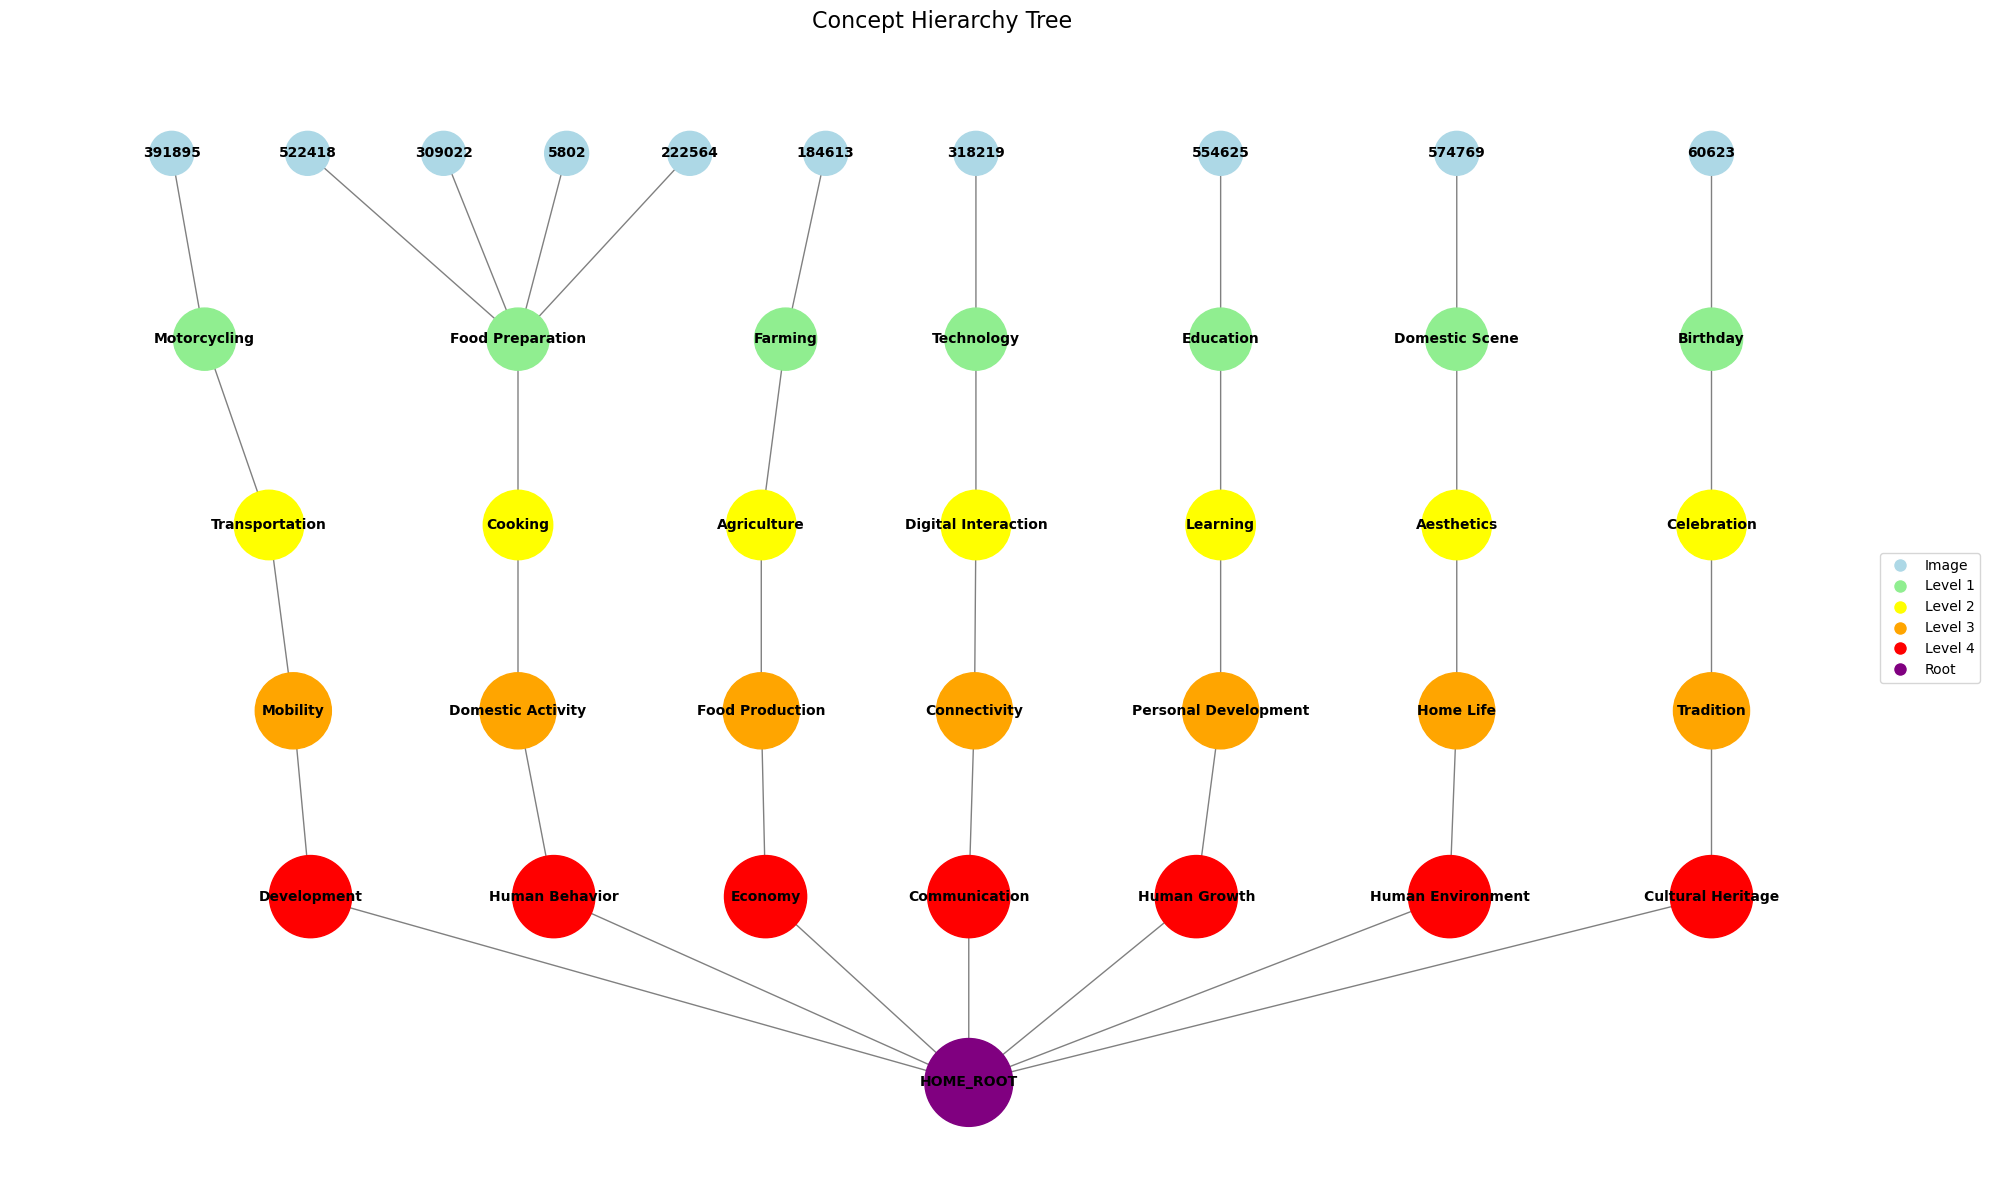

In [284]:
visualize_concept_hierarchy(G)

In [178]:
for n, d in G.nodes(data=True):
    print(n, d['type'])

391895 image
HOME_ROOT level5
Transportation level2
Mobility level3
Development level4
522418 image
Cooking level2
Domestic Activity level3
Human Behavior level4
184613 image
Agriculture level2
Food Production level3
Economy level4
318219 image
Digital Interaction level2
Connectivity level3
Communication level4
554625 image
Learning level2
Personal Development level3
Human Growth level4
574769 image
Aesthetics level2
Home Life level3
Human Environment level4
60623 image
Celebration level2
Tradition level3
Cultural Heritage level4
309022 image
5802 image
222564 image


/var/folders/ps/n599pbx125d96fdwq93jxcd40000gn/T/ipykernel_27263/2667467814.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


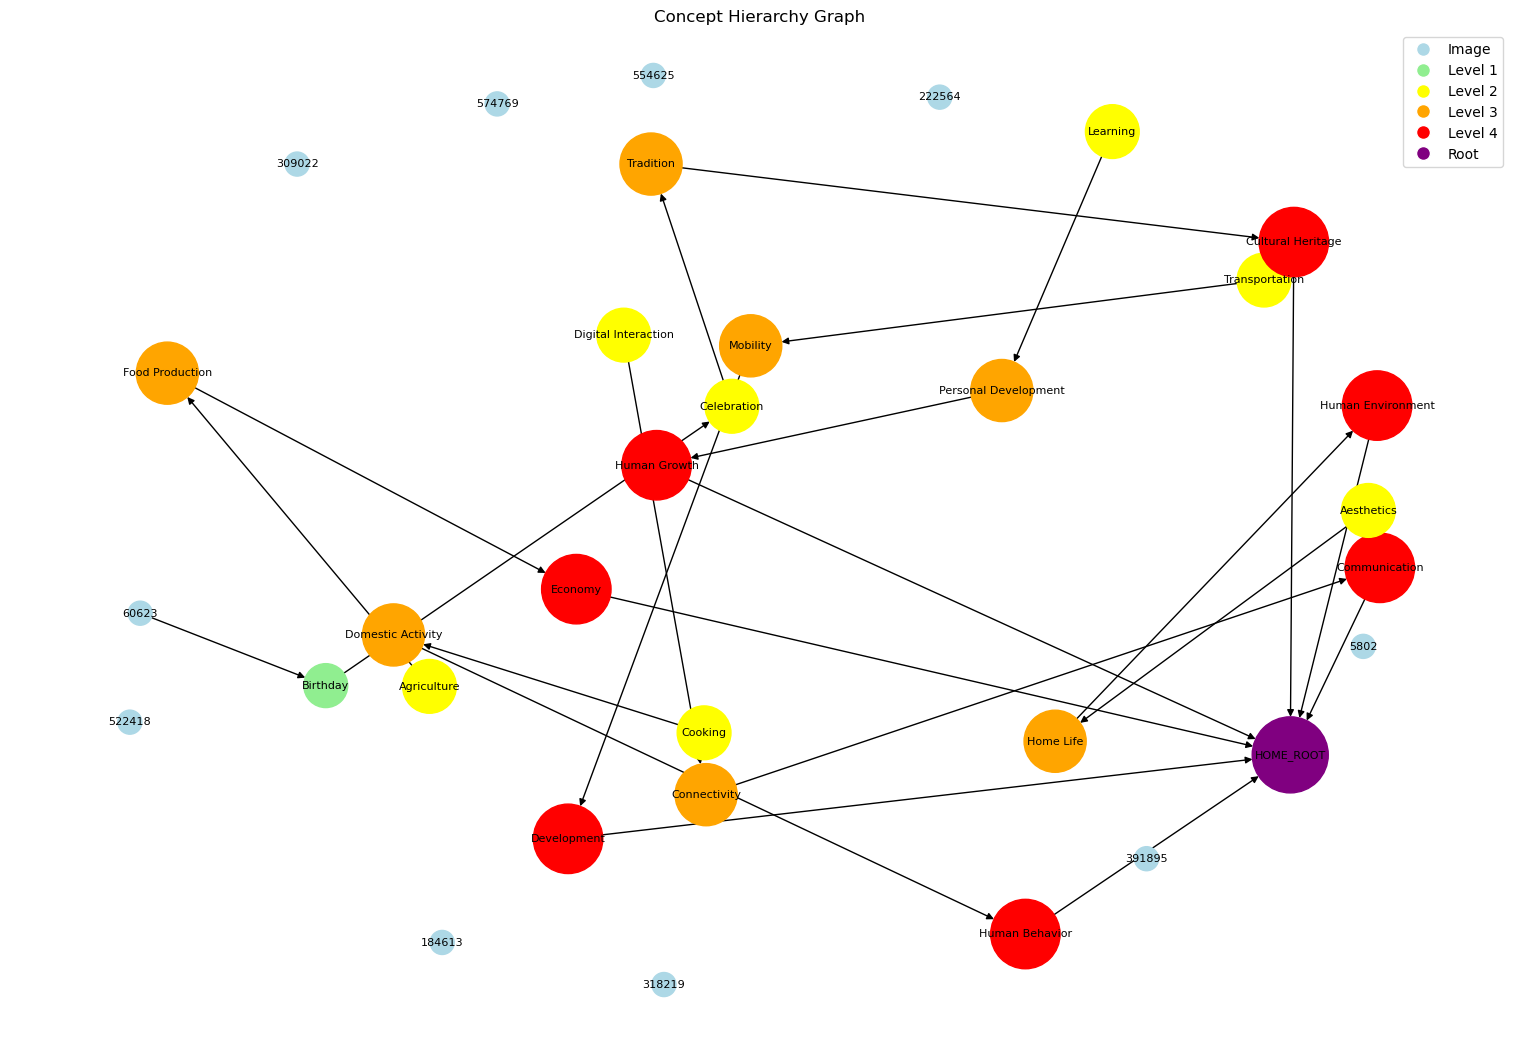

In [196]:
visualize_concept_hierarchy(G)